<a href="https://colab.research.google.com/github/Heatdh/MIUG-Proj/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    # Checking your venv for having necesarry packages and importing basic libs as trial

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
#import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [4]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn


Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [5]:
#df = pd.read_csv("../dataset/NC_policing.csv")
# (temp) for google collab use --> direct csv file upload
df = pd.read_csv("NC_policing.csv")

In [6]:
print (df.head())
print (df.dtypes)

  state   stop_date driver_gender  ...  officer_id drugs_related_stop district
0    NC  2000-07-31             M  ...       10606                NaN       E3
1    NC  2000-07-31             F  ...       10606                NaN       E3
2    NC  2000-07-31             F  ...       10606                NaN       E3
3    NC  2000-07-31             M  ...       10606                NaN       E3
4    NC  2000-07-31             M  ...       10606                NaN       E3

[5 rows x 14 columns]
state                  object
stop_date              object
driver_gender          object
driver_age            float64
driver_race_raw        object
driver_race            object
violation              object
search_type            object
contraband_found         bool
stop_outcome           object
search_basis           object
officer_id              int64
drugs_related_stop     object
district               object
dtype: object


In [7]:
y= df['stop_outcome']
X= df.drop(columns=['state','driver_race_raw','stop_date'])

In [8]:
df.isna().sum()
# should we drop drugs related stops ?? 


state                      0
stop_date                  0
driver_gender              0
driver_age                91
driver_race_raw            0
driver_race                0
violation                  0
search_type                0
contraband_found           0
stop_outcome               0
search_basis               0
officer_id                 0
drugs_related_stop    397708
district                  38
dtype: int64

In [9]:
X= df.drop(columns=['drugs_related_stop'])

In [10]:
df["driver_age"].fillna(df["driver_age"].mean(), inplace = True) 

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col= ["driver_gender","driver_race_raw","driver_race","violation","search_type","contraband_found",
      "stop_outcome","search_basis","officer_id","district","drugs_related_stop"
]
df_encoded = df
df_encoded[col]=df_encoded[col].apply(lambda col: le.fit_transform(col))
df_encoded.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,NC,2000-07-31,1,23.0,9,4,6,2,0,0,18,722,1,34
1,NC,2000-07-31,0,29.0,9,4,6,2,0,0,18,722,1,34
2,NC,2000-07-31,0,49.0,3,1,6,2,0,0,18,722,1,34
3,NC,2000-07-31,1,29.0,3,1,6,2,0,0,18,722,1,34
4,NC,2000-07-31,1,24.0,6,2,6,2,0,0,18,722,1,34


In [12]:
y= df_encoded['stop_outcome']
X= df_encoded.drop(columns=['state','driver_race_raw','stop_date'])

In [13]:
X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,1,23.0,4,6,2,0,0,18,722,1,34
1,0,29.0,4,6,2,0,0,18,722,1,34
2,0,49.0,1,6,2,0,0,18,722,1,34
3,1,29.0,1,6,2,0,0,18,722,1,34
4,1,24.0,2,6,2,0,0,18,722,1,34


In [14]:
df_encoded.isna().sum()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  int64  
 3   driver_age          402087 non-null  float64
 4   driver_race_raw     402087 non-null  int64  
 5   driver_race         402087 non-null  int64  
 6   violation           402087 non-null  int64  
 7   search_type         402087 non-null  int64  
 8   contraband_found    402087 non-null  int64  
 9   stop_outcome        402087 non-null  int64  
 10  search_basis        402087 non-null  int64  
 11  officer_id          402087 non-null  int64  
 12  drugs_related_stop  402087 non-null  int64  
 13  district            402087 non-null  int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 42.9+ MB
None


Model

In [15]:
from sklearn.model_selection import train_test_split
X= X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=200) 
X.dtypes

driver_gender         int64
driver_age            int64
driver_race           int64
violation             int64
search_type           int64
contraband_found      int64
stop_outcome          int64
search_basis          int64
officer_id            int64
drugs_related_stop    int64
district              int64
dtype: object

In [16]:
# testing with knn this is not a classifier 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


<Figure size 432x288 with 0 Axes>

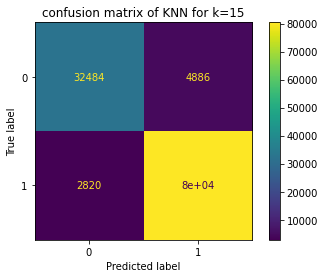

In [17]:
from sklearn.metrics import plot_confusion_matrix
# Plot the confusion matrix for the test set for the KNN classifier
plt.figure()
plot_confusion_matrix(knn, X_test, y_test)
plt.title('confusion matrix of KNN for k=15')
plt.show()


In [18]:
#first classifier without pca (no need for compression)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
num_splits = 5
#kfold = KFold(n_splits=num_splits, random_state=10, shuffle=True)

max_comp = X.shape[1]
param_grid = { 'n_neighbors':[5,10,15]}

#pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('estimator', KNeighborsClassifier())])
search = GridSearchCV(KNeighborsClassifier(),param_grid, n_jobs=-1, cv=2, scoring='accuracy', return_train_score=True)
search.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [19]:
print("accuracy" ,search.best_score_)
print(search.best_params_)

accuracy 0.9368968947630214
{'n_neighbors': 5}


In [20]:
best_estimator = search.best_estimator_
y_pred = best_estimator.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

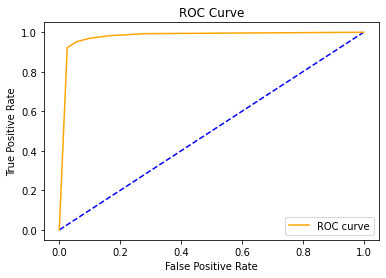

In [21]:
# Plot roc knn
from sklearn.metrics import roc_curve
y_pred_prob = search.best_estimator_.predict_proba(X_test)[:,1]
fp, tp, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fp, tp,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

Metrics functions

In [22]:

def separation(tn, fp, fn, tp):
   
    Y_0 = tn / (tn + fn)
    Y_1 = tp / (tp + fp)
  
    return Y_1, Y_0

def sufficiency(tn, fp, fn, tp):
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0
# switched tp and tn 
def independence (tp,tn,fn,fp ):
    return (tp + fp) / (tn + fp + fn + tp)



In [23]:
sep = separation(tn,fp,fn,tp)
suf = sufficiency(tn, fp, fn, tp)
ind = independence (tp,tn,fn,fp )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [24]:
print (sep)
print(suf)
print(ind)

(array([       nan, 0.9724877 , 0.94306755, 0.90695257, 0.85803534,
       0.77883844, 0.5       ]), 0.9298463748894783)
(array([0.        , 0.00036309, 0.00037503, 0.0003817 , 0.0003867 ,
       0.00039089, 0.0003937 ]), array([0.00000000e+00, 7.75277885e-07, 1.70879038e-06, 2.95559140e-06,
       4.82896770e-06, 8.37770840e-06, 2.97141499e-05]))
[0.00000000e+00 2.62017673e-05 2.79080013e-05 2.95351819e-05
 3.16281370e-05 3.52220918e-05 5.52577775e-05]


In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
#pipeline = Pipeline(steps=[('scaler',StandardScaler()),('pca', PCA()), ('estimator', LinearRegression())])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', logistic_Reg)])
#n_components = list(range(1,X.shape[1]))
C = np.logspace(-4, 4, 2)
parameters = dict(#pca__n_components=n_components,
                  logistic_Reg__C=C)
search_lin = GridSearchCV(pipe,parameters, cv=5, scoring='accuracy', return_train_score=True)
search_lin.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_Reg', LogisticRegression())]),
             param_grid={'logistic_Reg__C': array([1.e-04, 1.e+04])},
             return_train_score=True, scoring='accuracy')

In [28]:
print(search_lin.best_params_)
print(search_lin.best_score_)

{'logistic_Reg__C': 10000.0}
1.0


ValueError: ignored

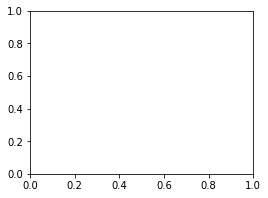

In [69]:
#plot the result
plt.figure(1, figsize=(4, 3))
plt.scatter(X_train,y_train)
plt.xlabel("Credit Balance")
plt.ylabel("Probability of Default")
plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show() 

In [29]:
best_estimator = search.best_estimator_
y_pred_lin = search_lin.best_estimator_.predict(X_test)

[[37370     0]
 [    0 83257]]


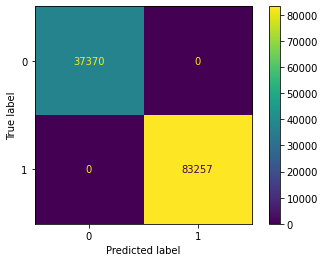

In [30]:
cm = confusion_matrix(y_test, y_pred_lin)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search_lin, X_test, y_test)  
print(cm)

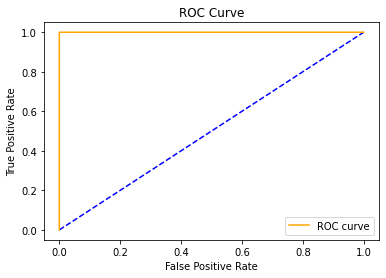

In [31]:
# Plot
from sklearn.metrics import roc_curve
y_pred_prob = search_lin.best_estimator_.predict_proba(X_test)[:,1]
fp, tp, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fp, tp,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

In [32]:
from sklearn.dummy import DummyClassifier
s ='most_frequent'

test_scores = []
dclf = DummyClassifier(strategy = s, random_state = 0)
dclf.fit(X_train, y_train)
score = dclf.score(X_test, y_test)
test_scores.append(score)
print (test_scores)

[0.6902020277384002]


In [33]:
df.loc[df['stop_outcome']==0,'stop_outcome'].count() # to check for the corecctness of the dummy classifier

123814

In [34]:
# calculate it manually 

In [35]:
X_train_fair = X_train.drop('driver_race',axis=1)
X_test_fair = X_test.drop('driver_race', axis=1)

In [36]:
X_train_fair.head()


,driver_gender,driver_age,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
126852,1,39,2,2,0,1,18,2224,1,55
393530,1,42,2,2,0,1,18,1942,1,31
254797,1,27,2,2,0,1,18,1496,1,56
271179,1,50,2,2,0,1,18,239,1,9
272000,1,42,2,2,0,1,18,1836,1,40


In [37]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [38]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

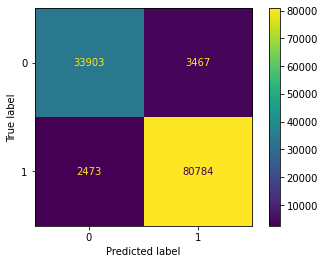

In [39]:
cm = confusion_matrix(y_test, y_pred_fair)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test) 

In [40]:
print(search.best_score_)

0.9385383358203653


In [41]:
X_train_fair = X_train.drop(columns=['driver_race','driver_gender','officer_id'],axis=1)
X_test_fair = X_test.drop(columns=['driver_race','driver_gender','officer_id'], axis=1)

In [42]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [43]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

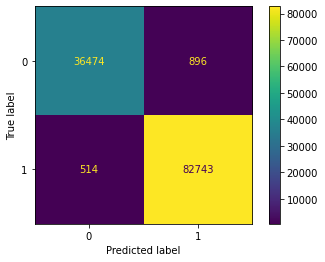

In [44]:
cm = confusion_matrix(y_test, y_pred_fair)
tn_, fp_, fn_, tp_ = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test) 

In [45]:
print(search.best_score_)

0.9803204718254814


In [46]:
sep_ = separation(tn_,fp_,fn_,tp_)
suf_ = sufficiency(tn_, fp_, fn_, tp_)
ind_ = independence (tp_,tn_,fn_,fp_ )

In [47]:
print (sep_)
print(suf_)
print(ind_)

(0.9892872942048566, 0.9861036011679464)
(0.9938263449319577, 0.023976451699223977)
0.6933688146103277
